# Exam 2

In this exam, you will request data from the [Zomato API](https://developers.zomato.com/api) and then train machine learning models on the data that you gather. You should have already registered an API key with Zomato, which will entitle you to 1000 API requests per day. This exam can be completed with fewer than 200 API requests.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import requests

apikey = "75158d6d9d7be13574279f873edd973e"

# Question 1 (4 points)

Determine the Zomato city ID for Chicago, IL. Then, use this city ID to create a `DataFrame` containing all of the cuisines in Chicago, along with their IDs. Display this `DataFrame`.

In [2]:
header = {"user-key": apikey}
resp = requests.get("https://developers.zomato.com/api/v2.1/cities?q=Chicago",
                    headers=header)
chicago_id = resp.json()['location_suggestions'][0]['id']

In [3]:
chicago_id

292

In [4]:
q = "https://developers.zomato.com/api/v2.1/cuisines?city_id=%d" % chicago_id
resp = requests.get(q, headers=header)

In [5]:
from pandas.io.json import json_normalize

cuisines = resp.json()['cuisines']
chicago_cuisines = json_normalize(cuisines).rename(
    columns={"cuisine.cuisine_name": "Cuisine",
             "cuisine.cuisine_id": "Id"}).set_index("Cuisine")
chicago_cuisines.head()

,Id
Cuisine,
Afghan,1035
African,152
American,1
Argentine,151
Armenian,175


# Question 2 (4 points)

Get the top 40 restaurants (sorted in `desc` order by `rating`) in Chicago for the following cuisines:

- Chinese
- Italian
- Mexican

Store the 120 results in a single `DataFrame` with the following columns:

- `res_id`: the ID for the Zomato restaurant
- `name`
- all of the `location` features (i.e., `address`, `locality`, `latitude`, `longitude`, `zipcode`, etc.)
- all of the `user_rating` features (i.e., `aggregate_rating`, `votes`, etc.)

Display this `DataFrame`.

In [6]:
ids = chicago_cuisines.loc[['Chinese', 'Italian', 'Mexican']]['Id'].astype(str)
ids

Cuisine
Chinese    25
Italian    55
Mexican    73
Name: Id, dtype: object

In [7]:
def getTop40(cuisine_id):
    q0 = ("https://developers.zomato.com/api/v2.1/search?"
          "entity_id=292&entity_type=city&cuisines=%s&sort=rating&order=desc" 
          % cuisine_id)
    q20 = ("https://developers.zomato.com/api/v2.1/search?"
           "entity_id=292&entity_type=city&cuisines=%s&sort=rating&"
           "order=desc&start=20" 
           % cuisine_id)
    r0 = requests.get(q0, headers=header).json()["restaurants"]
    r20 = requests.get(q20, headers=header).json()["restaurants"]
    return r0 + r20

In [8]:
chinese_rest = getTop40(ids[0])
italian_rest = getTop40(ids[1])
mexican_rest = getTop40(ids[2])

In [9]:
def buildTopDf(restaurants, cuisine):
    df = pd.DataFrame()
    for restaurant in restaurants:
        df = df.append(json_normalize(restaurant["restaurant"]["R"]).join([
            pd.DataFrame({"name": [restaurant["restaurant"]["name"]]}),
            pd.DataFrame({"cuisine": [cuisine]}),
            json_normalize(restaurant["restaurant"]["location"]),
            json_normalize(restaurant["restaurant"]["user_rating"])]),
                ignore_index=True)
    return df

In [10]:
restaurants_df = pd.DataFrame() 
for cuisine, restaurants in {"Chinese": chinese_rest,
                            "Italian": italian_rest,
                            "Mexican": mexican_rest}.items():
    restaurants_df = restaurants_df.append(
        buildTopDf(restaurants, cuisine),
        ignore_index=True)

In [11]:
restaurants_df.head()

,res_id,name,cuisine,address,city,city_id,country_id,latitude,locality,locality_verbose,longitude,zipcode,aggregate_rating,has_fake_reviews,rating_color,rating_text,votes
0,16735363,Joy Yee's Noodles,Chinese,521 Davis Street 60201,Chicago,292,216,42.0460805556,Evanston,"Evanston, Chicago",-87.6790305556,60201,4.5,0,3F7E00,Excellent,161
1,16749821,Yu's Mandarin Restaurant,Chinese,200 E Golf Road 60173,Chicago,292,216,42.0507000000,Schaumburg,"Schaumburg, Chicago",-88.0742638889,60173,4.5,0,3F7E00,Excellent,158
2,16743712,Chi Tung Restaurant,Chinese,"9560 S. Kedzie Avenue, Evergreen Park 60805",Chicago,292,216,41.7197000000,Evergreen Park,"Evergreen Park, Chicago",-87.7020000000,60805,4.5,0,3F7E00,Excellent,115
3,16747211,Chinese Kitchen,Chinese,"1003 W. Ogden Avenue, Suite B, Naperville 60563",Chicago,292,216,41.7848777778,Naperville,"Naperville, Chicago",-88.1680916667,60563,4.4,0,5BA829,Very Good,31
4,16751533,Tsing Tao Mandarin Chinese,Chinese,"537 Green Bay Road, Wilmette 60091",Chicago,292,216,42.0748055556,Wilmette,"Wilmette, Chicago",-87.7077638889,60091,4.4,0,5BA829,Very Good,22


# Question 3 (4 points)

For each of the 120 restaurants that you identified in Question 2, get the 5 most recent reviews. Store all of the  reviews in a `DataFrame` with the following columns:

- `rating`
- `review_text`
- all of the `user` features (such as `name`, `foodie_level`, `foodie_level_num`)

Display this `DataFrame`.

In [12]:
restaurant_ids = restaurants_df["res_id"]

In [13]:
from time import sleep
import warnings
warnings.filterwarnings("ignore")

reviews = []
for restaurant_id in restaurant_ids:
    q = ("https://developers.zomato.com/api/v2.1/reviews?res_id=%s&count=5" 
         % restaurant_id)
    r = requests.get(q, headers=header).json()["user_reviews"]
    reviews += r
    sleep(0.2)

In [14]:
reviews_df = pd.DataFrame()
for review in reviews:
    reviews_df = reviews_df.append(
        pd.DataFrame({"rating": [review["review"]["rating"]]}).join([
        pd.DataFrame({"review_text": [review["review"]["review_text"]]}),
        json_normalize(review["review"]["user"])]),
            ignore_index=True)

In [15]:
reviews_df.head()

,foodie_color,foodie_level,foodie_level_num,name,profile_deeplink,profile_image,profile_url,rating,review_text,zomato_handle
0,ffd35d,Foodie,3,Jason Jobe,zomato://u/30860504,https://b.zmtcdn.com/data/user_profile_picture...,https://www.zomato.com/users/jason-jobe-308605...,5.0,"Lively ambiance, but its all about the food. T...",NaN
1,ffd35d,Foodie,2,Tarek Anthony,zomato://u/33462700,https://b.zmtcdn.com/data/user_profile_picture...,https://www.zomato.com/users/tarek-anthony-334...,5.0,It was very good food a customer service Has ...,NaN
2,ffae4f,Big Foodie,6,Jalpa T,zomato://u/30483347,https://b.zmtcdn.com/data/user_profile_picture...,https://www.zomato.com/samosapop?utm_source=ap...,4.0,Yummy yummy yummy! This place is a gold mine. ...,samosapop
3,f58552,Super Foodie,8,Prapti,zomato://u/1510791,https://b.zmtcdn.com/data/user_profile_picture...,https://www.zomato.com/Praptisahni?utm_source=...,3.5,"Huge portions. good food, and they actually ma...",Praptisahni
4,ffd35d,Foodie,1,Mtnsguy,zomato://u/23884812,https://b.zmtcdn.com/images/user_avatars/mug_2...,https://www.zomato.com/users/mtnsguy-23884812?...,0.0,Stay away from this rapidly declining restaura...,NaN


# Question 4 (6 points)

Let's use the restaurants data that you obtained in Question 2 to train a machine learning model to predict whether a restaurant serves Chinese, Italian, or Mexican cuisine, given just the `latitude` and the `longitude` of the restaurant. (For a 1 point penalty, you can download `restaurants.csv` [from PolyLearn](https://polylearn.calpoly.edu/AY_2018-2019/mod/assign/view.php?id=343940), upload it to the current directory, and read in the file.)

Train a $k$-nearest neighbors model. Determine the optimal value of $k$. Calculate an estimate of the test precision and recall of your final model. Interpret these values in the context of this application.

In [16]:
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

scaler = RobustScaler()
model = KNeighborsClassifier()

pipeline = Pipeline([
    ("scaler", scaler),
    ("model", model)
])

X, y = restaurants_df[['latitude', 'longitude']], restaurants_df['cuisine']

{'model__n_neighbors': 9} 0.438734006734


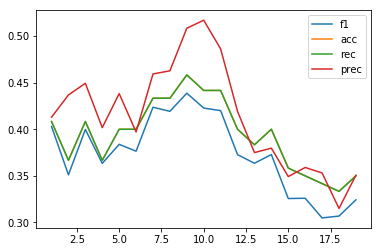

In [17]:
from sklearn.model_selection import GridSearchCV

k = range(1, 20, 1)
pg = {
    "model__n_neighbors": k
}

classifier_model = GridSearchCV(
    pipeline, pg, cv=5, scoring={
    "f1": "f1_macro",
    "acc": "accuracy",
    "rec": "recall_macro",
    "prec": "precision_macro"},
    refit="f1")

classifier_model.fit(X, y)

pd.DataFrame({"f1": classifier_model.cv_results_["mean_test_f1"],
              "acc": classifier_model.cv_results_["mean_test_acc"],
              "rec": classifier_model.cv_results_["mean_test_rec"],
              "prec": classifier_model.cv_results_["mean_test_prec"]
             }, 
             index=k).plot()
print(classifier_model.best_params_,
      classifier_model.best_score_)

From our plot, we can see that our features (latitude and longitude) are not good features for classifying our data. The model is only slightly better than randomly choosing a cuisine out of the three possible. We discovered that the best k-value for this model is 9. However, even with this best value, the model had low precision and recall. This implies that the model often mislabeled observations (False negatives, False positives).

# Question 5 (6 points)

Let's use the reviews data that you obtained in Question 3 to train a machine learning model to predict a rating, given just the `review_text`. (For a 1 point penalty, you can download `reviews.csv` [from PolyLearn](https://polylearn.calpoly.edu/AY_2018-2019/mod/assign/view.php?id=343940), upload it to the current directory, and read in the file.)

You will have to first convert the text of the review into quantitative features. Instead of including every word that appears, it is usually better to restrict to words that appear at least $m$ times, where $m$ is a hyperparameter. Plot the training and the test RMSE of a $10$-nearest neighbors model as a function of this hyperparameter $m$. What value of $m$ is optimal? What is the test RMSE of this optimal model? Interpret the test RMSE in the context of this application.

**Hint:** The hyperparameter $m$ corresponds to the `min_df=` argument of `CountVectorizer` and `TfidfVectorizer` in _scikit-learn_.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.neighbors import KNeighborsRegressor

vec = TfidfVectorizer()
model = KNeighborsRegressor(n_neighbors=10)

pipeline = Pipeline([
    ("vec", vec),
    ("model", model)
])

X, y = reviews_df['review_text'].fillna(""), reviews_df['rating']

CV RMSE: 1.98628188935 {'vec__min_df': 0}


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


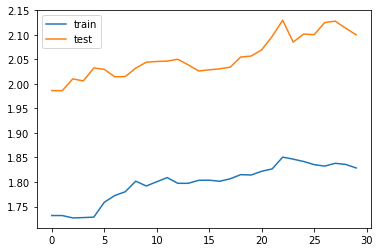

In [19]:
m = range(0, 30, 1)
pg = {
    "vec__min_df": m
}

regressor_model = GridSearchCV(
    pipeline, pg, cv=5, scoring="neg_mean_squared_error")

regressor_model.fit(X, y)

pd.DataFrame({"train": np.sqrt(-regressor_model.cv_results_['mean_train_score']),
              "test": np.sqrt(-regressor_model.cv_results_['mean_test_score'])}, 
             index=m).plot()
print("CV RMSE:", np.sqrt(-regressor_model.best_score_), 
      regressor_model.best_params_)

From our plot, we can see that the best value for our hyperparamater m is approximately 0. The test set shows this pretty clearly, but the training set has a few possible lower errors around k=4. However, we want to minimize our test error more than our training error, as the test error better captures our true error in predicting values our model has not seen. 

# Question 6 (6 points)

Let's use the reviews data to train a machine learning model to predict the `rating`, given just the `foodie_level_num` of the user. Fit an $80$-nearest neighbors model to predict `rating` from the `foodie_level_num`. Make a scatterplot showing the two variables, and add a curve to this scatterplot that shows the predicted `rating` as a function of `foodie_level_num`. What is the test RMSE of this model?

Then, combine this model with your (optimal) model from Question 5 into a ensemble model. How does the test RMSE of the ensemble model compare to the test RMSE of each individual model?

**Hint:** Feel free to borrow the `RegressionEnsembler` [code that I wrote](https://github.com/dlsun/data-science-book/blob/master/Chapter%205%20Machine%20Learning%20and%20Regression%20Models/5.6%20Ensemble%20Methods.ipynb). However, it will not work out of the box because the two models you are trying to combine use different variables as input. So if you use my `RegressionEnsembler`, you will have to adapt it to make it work for this problem.

In [20]:
scaler = RobustScaler()
model = KNeighborsRegressor(n_neighbors=80)

pipeline = Pipeline([
    ("scaler", scaler),
    ("model", model)
])

X, y = reviews_df[['foodie_level_num']], reviews_df['rating']

In [21]:
regressor_model = GridSearchCV(
    pipeline, {}, cv=5, scoring="neg_mean_squared_error")

regressor_model.fit(X, y)

pred = pd.DataFrame({"x": range(1, 14)})
pred["y_pred"] = regressor_model.predict(pred)
pred = pred.set_index("x")

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CV RMSE: 1.4179280817


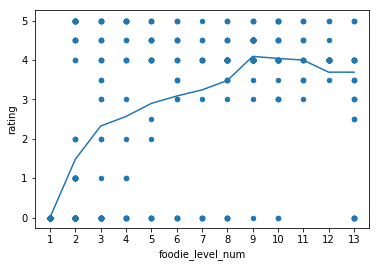

In [22]:
import matplotlib.pyplot as plt

(pd.DataFrame({"foodie_level_num": X['foodie_level_num'], "rating": y})
    .plot.scatter(x="foodie_level_num", y="rating", xticks=range(1, 14)))
plt.plot(pred)
print("CV RMSE:", np.sqrt(-regressor_model.best_score_))

This model did considerably better than the previous model. We can infer then that the "foodie_level_num" is a better predictor of rating than the actual review itself. 

In [23]:
X, y = (reviews_df[["review_text", "foodie_level_num"]], 
    reviews_df['rating'])
X["review_text"] = X["review_text"].fillna("")

In [24]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression

class RegressionEnsembler(BaseEstimator, RegressorMixin):  
    def __init__(self, estimators, learn_weights=False):
        self.estimators = estimators
        self.learn_weights = learn_weights
        
    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        
        self.estimators[0].fit(X["review_text"], y)
        self.estimators[1].fit(X["foodie_level_num"].values.reshape(-1, 1), y)        
        
        if self.learn_weights:
            predictions = []
            predictions.append(self.estimators[0]
                            .predict(X["review_text"]))
            predictions.append(self.estimators[1]
                            .predict(X["foodie_level_num"].values.reshape(-1, 1)))
            Y_ = np.column_stack(predictions)
        
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        predictions = []
        predictions.append(self.estimators[0]
                        .predict(X["review_text"]))
        predictions.append(self.estimators[1]
                        .predict(X["foodie_level_num"].values.reshape(-1, 1)))
        Y_ = np.column_stack(predictions)

        if self.learn_weights:
            return self.ensembler.predict(Y_)
        else:
            return Y_.mean(axis=1)

In [30]:
model1 = Pipeline([
    ("vec", TfidfVectorizer()),
    ("model", KNeighborsRegressor(n_neighbors=10))
]) 

model2 = Pipeline([
    ("scaler", RobustScaler()),
    ("model", KNeighborsRegressor(n_neighbors=80))
])
ensemble_avg = RegressionEnsembler([model1, model2])
ensemble_meta = RegressionEnsembler([model1, model2], True)

In [31]:
regressor_model = GridSearchCV(
    ensemble_avg, {}, cv=5, scoring="neg_mean_squared_error")

regressor_model.fit(X, y)
print("CV RMSE (avg):", np.sqrt(-regressor_model.best_score_))

CV RMSE (avg): 1.54528666685


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [33]:
regressor_model = GridSearchCV(
    ensemble_meta, {}, cv=5, scoring="neg_mean_squared_error")

regressor_model.fit(X, y)
print("CV RMSE (meta):", np.sqrt(-regressor_model.best_score_))

CV RMSE (meta): 1.42645290769


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Text(4,1,'$R^2$ = 0.58')

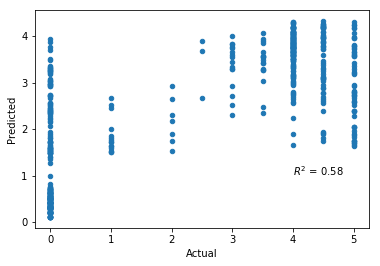

In [34]:
from sklearn.metrics import r2_score

y_pred = regressor_model.predict(X)
(pd.DataFrame({"Actual": y, "Predicted": y_pred})
    .plot.scatter(x="Actual", y="Predicted"))
plt.text(x=4, y=1, s="$R^2$ = {:3.2f}".format(r2_score(y, y_pred)))

Using the example code given to us, I was able to build an ensemble of our best (KNN) models for this data. The ensemble method actually performs slightly worse than the straight `KNeighborsRegressor` on the foodie levels, and performs much better than regression over just the text data by itself. The meta-learner ensemble does in fact perform better than the straight averagered model in this case, which I thought otherwise, We can also see from the scatterplot that our predictions have a very moderate positive correlation with the true values. If the correlation was very high (closer to 1.0), we would know that our model is overfitting on our training data.

# Submission Instructions

Once you are finished, follow these steps:

1. Restart the kernel and re-run this notebook from beginning to end by going to `Kernel > Restart Kernel and Run All Cells`. (If you are close to your API quota limit, do not re-run the code for Questions 1-3.)
2. If this process stops halfway through, that means there was an error. Correct the error and repeat Step 1 until the notebook runs from beginning to end.
3. Double check that there is a number next to each code cell and that these numbers are in order.

Then, submit your exam as follows:

1. Go to `File > Export Notebook As > PDF`.
2. Double check that the entire notebook, from beginning to end, is in this PDF file. (If the notebook is cut off, try first exporting the notebook to HTML and printing to PDF.)
3. Upload the PDF [to PolyLearn](https://polylearn.calpoly.edu/AY_2018-2019/mod/assign/view.php?id=343940).